# パターン認識演習　ニューラルネットワークによるサイン関数の回帰
下記の点を目的とするニューラルネットワークの演習です。Moodleの解説動画を視聴したあと、上から順に説明を読み、プログラムを実行してください。目的は次の通りです。

* ニューラルネットワークで回帰問題を解くことを体験する
* 回帰において個々のニューロンの出力を基底関数と解釈出来ることを理解する
* 初期値に依存して学習結果や結果に至る過程が異なりうることを理解する

# 0 各種モジュールの読み込み
下記左の三角形をクリックして実行してください。プログラムの変更は不要です。

In [27]:
# Macの問題回避
# import os
# import platform
# if platform.system() == 'Darwin':
#     os.environ['KMP_DUPLICATE_LIB_OK']='True'
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Activation, Input
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt


# 1. 準備：活性化関数と線形変換
この演習で作るNeural Networkでは中間層の活性化関数にtanhを採用する。準備として、tanh(x)に慣れておく

# 1.1 y = tanh(x)の描画
sigmoid関数と似ている形。値域が(-1,+1)であることに注意。



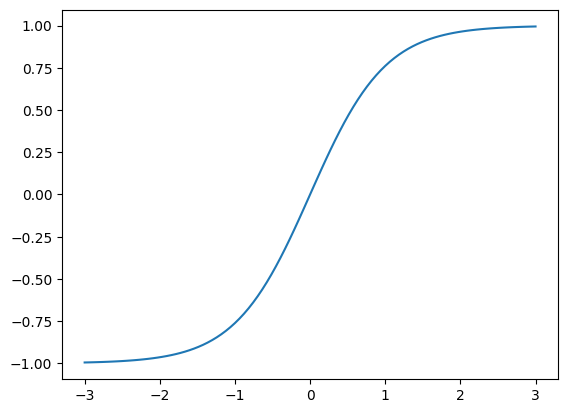

In [11]:
# 関数を表示する定義域 [-10,10]
x = np.linspace(-3.0,3.0,100 )
y = np.tanh( x )
# 描画
plt.plot( x, y )
plt.show()

# 1.2 y = tanh(w*x+b)の描画
中間層のニューロンがどのような「基底関数」を獲得しうるかを確認します。
結線の重みは、f(x) = tanh(wx+b)と表したときのwとbです。

# 1.2.1 wが負になると左右反転します
下記を実行してwが負になると左右反転する。w=-1.0のときのグラフを確認すること。

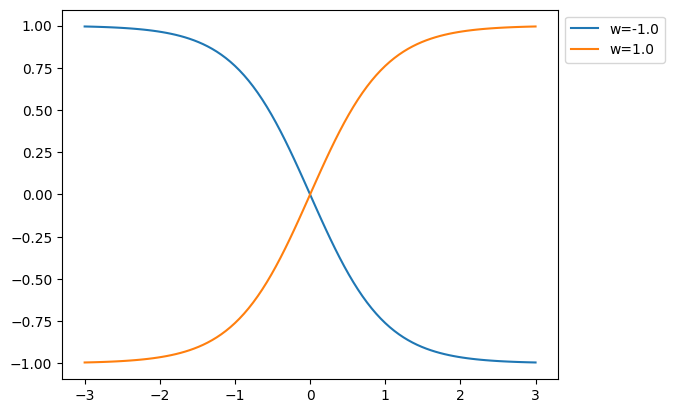

In [12]:
# 係数の符号を反転させて描画する
for w in (-1.0, 1.0):
  y = np.tanh( w*x )
  plt.plot( x, y, label=f'w={w}')
plt.legend(bbox_to_anchor=(1, 1) )
plt.show()

# 1.2.2 |w|が変化すると、入力される変数xの縮尺が変わります。
|w|を1より小さくすると「横に広がる」ことになり、1より大きくすると「横に縮む」。描画されるグラフそれぞれのwの値を確認すること。

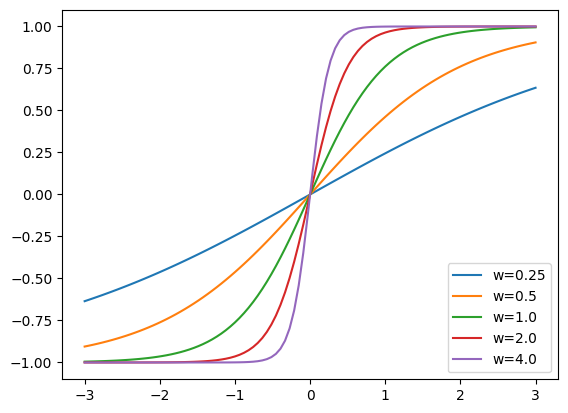

In [13]:
# 係数wを2^iで表して、i=-2, -1, 0, 1, 2で変化させる
for i in range(-2, 3):
  w = 2.0**i
  y = np.tanh( w*x )
  plt.plot( x, y, label=f'w={w}' )
plt.legend(bbox_to_anchor=(1, 0), loc='lower right' )
plt.show()

# 1.2.3 bが変化すると左右に並進します
bが変化するとグラフの位置が変化する。描画されるグラフそれぞれのbの値を確認すること。

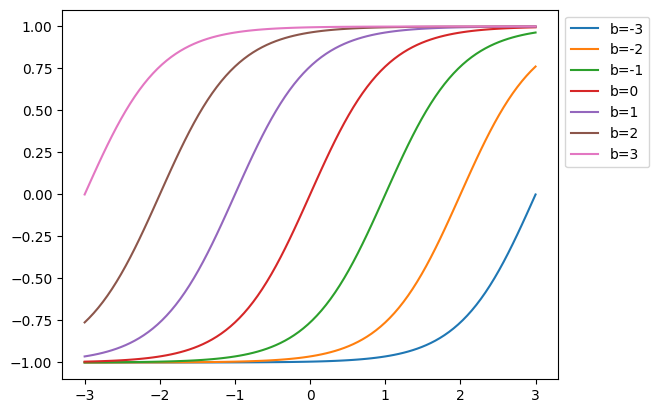

In [14]:
# w=1のままbを変化させる
w=1.0
for b in range(-3, 4):
  y = np.tanh( w*x + b )
  plt.plot( x, y, label=f'b={b}')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# 2. 実験の開始：訓練データの生成
訓練用のデータ (x,y)と訓練中の性能評価用のデータ(x_test, y_test)を生成します。訓練用のデータも評価用データもNUM個ずつ生成します。
* *x*: 0以上1未満の乱数。 サイズ NUM の配列
* *y*: *y* = sin (2π*fx* )

下記プログラム中の変数は次のとおり
* pi: 円周率
* NUM: 訓練データの数・評価用データの数
* FREQ: 回帰したい関数は三角関数。その周波数。

下記二つのセルを、三角形をクリックすることで上から順に実行してください。
2番目の三角形をクリックすると、生成したデータのグラフが表示されます。FREQ=2の場合、2つの波が続くグラフになるはずです。（点が密集して分かりにくいですが、青い点は順序のランダムなNUM個の点です）

In [15]:
# 訓練データの生成
# 円周率　π
pi = np.pi
# 周波数
FREQ = 2.0
# 訓練データの数・評価用
NUM = 500
# 誤差の標準偏差
SCALE = 0.2

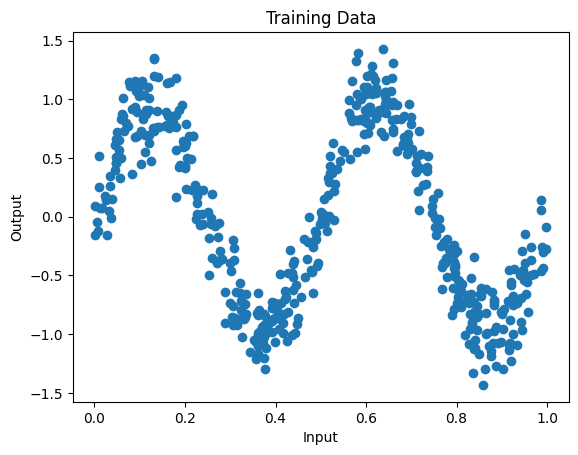

In [16]:
# 学習データの生成 (eは誤差)
e = np.random.normal(loc=0.0, scale=SCALE, size=NUM)
x = np.random.rand( NUM )
y = np.sin( 2.0*pi*FREQ*x ) + e
# 評価データの生成
e_test = np.random.normal(loc=0.0, scale=SCALE, size=NUM)
x_test = np.random.rand( NUM )
y_test = np.sin( 2.0*pi*FREQ*x_test ) + e_test
# 学習データのグラフの表示（横軸x, 縦軸y)
plt.scatter(x,y)
plt.title('Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# 3. ニューラルネットワークの構築
次に、入力→中間層→出力 の3層からなるニューラルネットワークをデザインします。入力xも出力yもスカラなので、入力層のニューロンは1つ、出力層のニューロンの出力も1つです。

プログラムの読み方を簡単に解説します。

* **model = Sequential():** 層を積み重ねたニューラルネットワークをこれから作る宣言です。
* **model.add:**  層を追加します。2層目から順に追加します
  * 1層目は2層目を作るときにデザイン出来てしまいます
* **Dense:** 全結合の層を追加します。つまり、前の層の全てのニューロンを、いま作る層のニューロン全てと結合させます。
  * 引数によりニューロンの数と活性化関数と入力の次元を指定します。
  * 2層目はZ_NUM個のニューロンを用意して、それらの活性化関数はtanhにして、前の層の出力は1次元とします。
  * 3層目はニューロンは一つで、活性化関数は恒等関数(linear)です。
* **optimizers:** 最適化の準備をします。ここではStatistical Gradient Descentを採用します。
  * **learning_rate:** 勾配ベクトルに掛ける係数（資料ではε）
  * **decay:**Learning rateを学習が進むにつれて小さくするための係数です。学習の初期には大胆に係数を更新して、次第に更新に慎重になるための仕掛けです。
* **model.compile:**コスト関数と最適化法を指定します
  * **loss='mean_square_error':** 二乗誤差をコストにします。
  * **'sgd':** 確率的勾配法で最適化します。

下のセルを三角形を上から順にクリックすることで実行してください。最初のセルで、2層目のニューロンの数を指定するための変数Z_NUMを定めます。

In [17]:
# 中間層のニューロンの数
Z_NUM = 6

In [31]:
# 層の構築
model = Sequential()
# 2層目の追加
model.add(Dense(Z_NUM, activation = 'tanh', input_dim = 1))
# 3層目の追加
model.add(Dense(1, activation = 'linear'))
# 確率的勾配法のデザイン
# sgd = optimizers.SGD( learning_rate = 0.01, decay = 1e-6 )
sgd = optimizers.legacy.SGD( learning_rate = 0.01, decay = 1e-6 )
# コスト関数(loss関数)と最適化法の指定
model.compile( loss = 'mean_squared_error', optimizer = 'sgd' )

# 4. 学習
学習を開始します。
* **model.fit:** 最適化計算により係数を更新します。
  * **epochs:** ニューラルネットワークの重み係数を更新する回数を指定します。全てのデータを1回ずつ使って更新すると1 epochです。
  * **batch_size:** 沢山ある学習データのうち、batch_size個のデータのみをランダムに選んで更新に使います。1 epochの更新のためにはバッチの選択と更新を複数回実行しなければいけません。
* **model.evaluate:** 学習には使っていないデータにより現状のニューラルネットワークの性能を評価します。
* **print(score):** 1pochごとに評価値を印字します。

下のセルを、三角形を上から順にクリックすることで実行してください。最初のセルで、パラメータの更新回数を指定するための変数EPOCHを定めます。

EPOCH=20000のとき、実行時間は20分程度かかります。気長に待って下さい。ニューラルネットワークの係数の初期値が毎回違うので、学習過程は実行のたびに異なります。lossの値が0.1より小さくなれば「成功」です。lossの下がり方は一様ではなく、途中で急激に下がりだすこともあります。

運悪くlossが下がらないこともあります。何度か実行して下さい。**再実行するときは「3. ニューラルネットワークの構築」に遡って、順に実行し直して下さい。**

In [ ]:
# パラメータの更新回数の指定
EPOCH = 20000
# バッチサイズ（一度に見るデータの数）
BATCH_SIZE = 64

In [ ]:
###### 学習開始
result = model.fit(x, y, epochs=EPOCH, batch_size = BATCH_SIZE)
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(score)

# 5. 学習過程の確認
横軸にエポック数、縦軸にコスト関数の値を示すグラフを表示します。多くの人は、ロスの変化が一様ではないことに気付くことになる。

In [ ]:
# Lossの変化の可視化（横軸：エポック、縦軸：コスト関数）
plt.plot(range(1, EPOCH+1), result.history['loss'], label="LOSS")
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend()
plt.show()

# 6. 学習結果の確認
学習済みのニューラルネットワークに新しいデータを入力して、出力を確認する
* **test_input:** 新規に生成したデータ。0から1まで0.01刻みで値を生成
* **model_predict:**学習済みニューラルネットワークによる出力 

表示されるグラフでは、細い赤線がニューラルネットワークによる回帰結果を示す。

In [ ]:
%matplotlib inline

###### 学習データの描画
plt.scatter(x,y, label='Training Data')

###### 新規入力データに対する予測結果の描画
test_input = np.arange(0,1,0.01)
test_output = model.predict(test_input)
test_output.reshape(len(test_output),)
plt.plot(test_input, test_output, label='Regression', color='red', linewidth=5.0)
plt.legend()
plt.show()

# 7. 各ニューロンが獲得した基底関数の表示
下記を実行すると、Z_NUM個のニューロンが獲得した基底関数を色を分けて表示されます。位置やスケールの異なるtanh関数を足し合わせることにより、回帰を実現したということです。

In [ ]:
###### Visualization
# Get Coefficietns
a = model.layers[0].get_weights()
b = model.layers[1].get_weights()

# 関数を表示する定義域
u = (np.arange(0,1,0.01))[:,np.newaxis] # column vector
# 中間層への入力・重みとの線形演算
w = np.dot(u, a[0])+a[1]
# 活性化関数 (tanh)
v = np.tanh(w)
# 各ニューロンの出力の計算
out = np.dot(v,b[0])+b[1]
# 表示
plt.scatter(x,y, label='Training data')
plt.plot(u,out, label='Regression', color='red', linewidth=5.0)
for i in range(Z_NUM):
    plt.plot(u,v[:,i], label=i)
plt.legend(bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,
           ncol=1,
           mode="expand")
plt.show()




# 8. ニューラルネットワークの利用上の注意（外挿について）
データの「外挿」については注意が必要です。このことを確認します。

**学習データに含まれていなかった領域（今回の例でいえば、横軸に沿って学習データが分布している範囲（0〜1）の外側）について回帰関数がどのような形になるかは、学習時には何も考えていない。**　特に学習データが少ないときには、このことを忘れがちなので注意してください。異常検知に利用できるかどうかにも関わる問題です。

下記を実行して、（当然のことながら）データの与えられている部分だけで回帰がなされていることを確認してください。赤線が回帰の結果です。

In [ ]:
###### 学習データの描画
plt.scatter(x,y, label='Training Data')

###### 新規入力データに対する予測結果の描画（今回は外挿する）
test_input = np.arange(-2,3,0.01)
test_output = model.predict(test_input)
test_output.reshape(len(test_output),)
plt.plot(test_input, test_output, label='Regression', color='red', linewidth=2.0)
plt.legend()
plt.show()

# 課題: 下記それぞれの画像を保存し、Moodleの当該箇所に提出せよ。

1.   最初の一通りの実行結果のうち、次の画像を保存して当該箇所に提出せよ。
* (1) 5.「学習過程の確認」の実行結果のグラフ
* (2) 7.「各ニューロンが獲得した基底関数の表示」の実行結果のグラフ
* (3) 8.「ニューラルネットワークの利用上の注意」の実行結果のグラフ
2.   プログラムを修正せずに3.「ニューラルネットワークの構築」から順に最後まで再度実行せよ。ニューラルネットワークの重みの初期値が違うため、全く同じプログラムであるにも関わらず最初とは（微妙に）異なる実行結果が得られる。特に基底関数の組み合わせは大きく変化する場合が多い。
* (1) 7.「各ニューロンが獲得した基底関数の表示」の実行結果のグラフ
* (2) 8.「ニューラルネットワークの利用上の注意」の実行結果のグラフ
3.   3.「ニューラルネットワークの構築の最初のセルをZ_NUM=6からZ_NUM=3に修正して、当該セルから順に最後まで再度実行せよ。基底関数の数がサイン関数を回帰するには不足するため回帰に失敗する。
* (1) 5.「学習過程の確認」の実行結果のグラフ
* (2) 7.「各ニューロンが獲得した基底関数の表示」の実行結果のグラフ
* (3) 8.「ニューラルネットワークの利用上の注意」の実行結果のグラフ

